<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/StrongPeriodicBC_OneComp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the solver

In [0]:
# This demo solves the transformed Bloch-Torrey equation applied to diffusion MRI 
# using the standard finite element method coupled with the theta-method 
# for the space discretization.

# This demo allows a single domain with periodic boundaries and the spins can
# enter and exit the computational domain freely by using the periodic boundary
# conditions

# Copyright (C) 2017 Van-Dang Nguyen

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-10

# Setting a working environment

In [859]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

# dolfin setting
q_degree = 3
dx = dx(metadata={'quadrature_degree': q_degree})


dolfin version: 2018.1.0


#Pre-defined functions

In [0]:
def FT(t, delta, Delta):
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
    return ft1 + ft2;  

def iFT(t, delta, Delta): # integrate ft
    ft1 = t*(t>=0 and t<delta) 
    ft2 = delta*(t>=delta and t<Delta) 
    ft3 = (delta - t + Delta)*(t>=Delta and t<=Delta+delta) 
    return ft1 + ft2 + ft3;  

def FuncF(ift, gnorm, g, ur, ui, vr, vi, K):
    Fr =   ift*gnorm*(inner(g,K*grad(ui))+inner(grad(ui),K*g))*vr - inner(g,K*g)*gnorm*gnorm*ift*ift*ur*vr-K*inner(grad(ur), grad(vr))
    Fi = - ift*gnorm*(inner(g,K*grad(ur))+inner(grad(ur),K*g))*vi - inner(g,K*g)*gnorm*gnorm*ift*ift*ui*vi-K*inner(grad(ui), grad(vi))
    return Fr + Fi

def outer_interface(ift, gnorm, K, n, ur, ui, vr, vi, g):
    F_bcr =  (ift*gnorm+1e-16)*inner(K*g, n)*ui*vr 
    F_bci = -(ift*gnorm+1e-16)*inner(K*g, n)*ur*vi
    return F_bcr + F_bci

def ThetaMethod_L(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0,k,  K, theta, n):
    L1 = (u1r_0/k*v1r + u1i_0/k*v1i +theta*FuncF(ift, gnorm, g, u1r_0, u1i_0, v1r, v1i, K))*dx
    L1_outer_bc = -theta*outer_interface(ift, gnorm, K, n, u1r_0, u1i_0, v1r, v1i, g)*ds
    return L1 + L1_outer_bc


def ThetaMethod_a(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0,k, K, theta, n):
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ift, gnorm, g, u1r  , u1i  , v1r, v1i, K))*dx
    a1_outer_bc = theta*outer_interface(ift, gnorm ,K, n, u1r, u1i, v1r, v1i, g)*ds
    return a1 + a1_outer_bc

def b2g(bvalue, delta, Delta, nperiod, stype):
  gnorm = 0;
  if (stype == 'PGSE'):
      gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
  if (stype == 'cos_OGSE'):
      gnorm = sqrt(bvalue/(1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi)));
  return gnorm;

def g2b(gnorm, delta, Delta, nperiod, stype):
  bvalue = 0;
  if (stype == 'PGSE'):
      bvalue = gnorm*gnorm*delta*delta*(Delta-delta/3.0);
  if (stype == 'cos_OGSE'):
      bvalue=gnorm*gnorm*1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi);
  return bvalue;  

# Generate a periodic mesh

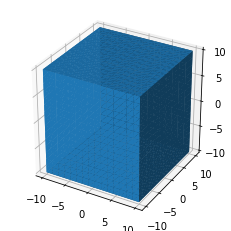

In [862]:
xmin, ymin, zmin, xmax, ymax, zmax = -10, -10, -10, 10, 10, 10
nx, ny, nz = 15, 15, 15;
# mesh = RectangleMesh(Point(xmin, ymin), Point(xmax, ymax), nx, ny, "right")
mesh = BoxMesh(Point(xmin, ymin, zmin), Point(xmax, ymax, zmax), nx, ny, nz)

plot(mesh)

tol = 1e-6*mesh.hmin();
gdim = mesh.geometry().dim()

PeriodicDir = [1, 1, 1]

if gdim==2:
  gdir = Point(1,1);

if gdim==3:
  gdir = Point(1,1,1);
  
gdir /= gdir.norm()

class PeriodicBD(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0) 
        bcx = abs(x[0] - xmin)<tol
        bcy = abs(x[1] - ymin)<tol
        bcz = 0
        if (gdim==3):
          bcz = abs(x[2] - zmin) < tol
          
        return bool((bcx or bcy or bcz) and on_boundary)

    def map(self, x, y):
        Lxx, Lyy, Lzz = 0, 0, 0
        if PeriodicDir[0] == 0:
          Lxx = 1e10;
        if PeriodicDir[1] == 0:
          Lyy = 1e10;
        if PeriodicDir[2] == 0:
          Lzz = 1e10;
          
        if abs(x[0] - xmax) < tol:
            y[0] = x[0] - (xmax-xmin) + Lxx
            y[1] = x[1]
            if (gdim==3):
              y[2] = x[2]
        if abs(x[1] - ymax) < tol:
            y[0] = x[0]
            y[1] = x[1] - (ymax-ymin) + Lyy 
            if (gdim==3):
              y[2] = x[2]
        if (gdim==3) and abs(x[2] - zmax)<tol:
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - (zmax-zmin) + Lzz 

In [0]:
def MyFunctionSpaces(mesh, porder):
  Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
  V = FunctionSpace(mesh,Ve)
  TH = MixedElement([Ve,Ve])
  W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBD())
  return V, W

V, W = MyFunctionSpaces(mesh, 1)
v = TestFunction(W)
v1r, v1i = v[0], v[1]
u = TrialFunction(W);
u1r, u1i = u[0], u[1]

# Pre-defined parameters

In [0]:
porder = 1;
delta, Delta = 50000, 50000
t, T = 0, Delta+delta;
K = 3e-3;
nskip = 2;
bvalue = 2000;
nperiod = 0
theta = 0.5;
Nsteps = 70
k = T/Nsteps;
stype = 'PGSE'
g = Constant( (gdir.x(), gdir.y()) )
if (gdim==3):
  g = Constant( (gdir.x(), gdir.y(), gdir.z()) )

t=0.000000  gnorm: 0.000005 ift: 0.000000 ft: 1.000000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t=2857.142857  gnorm: 0.000005 ift: 2857.142857 ft: 1.000000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t=5714.285714  gnorm: 0.000005 ift: 5714.285714 ft: 1.000000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) 

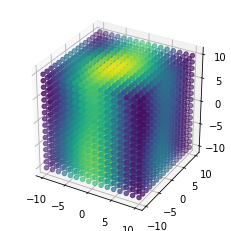

In [864]:
# convert bvalue to gvalues
gnorm = b2g(bvalue, delta, Delta, nperiod, stype)

# Initial conditions
Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mesh, degree=1);
if gdim==3:
  Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mesh, degree=1);

Dirac_Delta = interpolate(Dirac_Delta, V);
File("Dirac.pvd")<<Dirac_Delta;

u_0 = Function(W);
assign(u_0.sub(0), Dirac_Delta)
u1r_0, u1i_0 = split(u_0)

stepcounter = 0;

n = FacetNormal(mesh);

ift_prev = iFT(t, delta, Delta);

start_time = time.time()
  
while t < T+k: # Time-stepping loop

    ft = FT(t, delta, Delta);
    ift = iFT(t, delta, Delta);
    
    if stepcounter % nskip == 0:
        print('t=%f '%t, 'gnorm: %f'%gnorm, 'ift: %f'%ift,'ft: %f'%ft);

    L = ThetaMethod_L(ift_prev, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0, k, K, theta, n);
    a = ThetaMethod_a(ift, gnorm, g, u1r, u1i, v1r, v1i, u1r_0, u1i_0, k, K, theta, n);
    A = assemble(a);
    b = assemble(L);
 
    u = Function(W)
    solve(A,u.vector(),b, "bicgstab");
    
    u1r_0, u1i_0 = split(u)
    
    ift_prev = ift
    t += k;
    stepcounter += 1;
    
elapsed_time = time.time() - start_time
print("Elapsed time: %f seconds"%elapsed_time)
    
plot(u1r_0);
signal = assemble((u1r_0)*dx)/assemble(Dirac_Delta*dx);
print('b:',bvalue, 'Signal: %.3e'%signal, 'Exact signal: %.3e'%(exp(-bvalue*K)))
